<a href="https://colab.research.google.com/github/siyeol/Few-Shot-Learning/blob/main/Reptile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Resources Used Below (for code)

--  https://www.askpython.com/python/examples/load-and-plot-mnist-dataset-in-python

-- https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data

In [ ]:
import keras
from keras.datasets import mnist

## Load Data and Assertions from https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

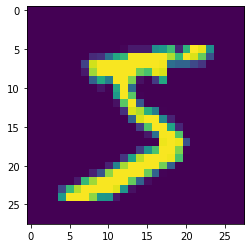

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
plt.show()

# Next, we will use code from the Reptile Google Colab notebook

-- https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/reptile.ipynb#scrollTo=qFE4oLzO32G5

-- Reptile Paper: https://arxiv.org/pdf/1803.02999.pdf

# Few-Shot learning with Reptile

**Author:** [ADMoreau](https://github.com/ADMoreau)<br>
**Date created:** 2020/05/21<br>
**Last modified:** 2020/05/30<br>
**Description:** Few-shot classification of the Omniglot dataset using Reptile.

## Introduction

The [Reptile](https://arxiv.org/abs/1803.02999) algorithm was developed by OpenAI to
perform model agnostic meta-learning. Specifically, this algorithm was designed to
quickly learn to perform new tasks with minimal training (few-shot learning).
The algorithm works by performing Stochastic Gradient Descent using the
difference between weights trained on a mini-batch of never before seen data and the
model weights prior to training over a fixed number of meta-iterations.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

## Define the Hyperparameters


In [ ]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

#meta iters should be 2000, previously 500
meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5


## Prepare the data

The [Omniglot dataset](https://github.com/brendenlake/omniglot/) is a dataset of 1,623
characters taken from 50 different alphabets, with 20 examples for each character.
The 20 samples for each character were drawn online via Amazon's Mechanical Turk. For the
few-shot learning task, `k` samples (or "shots") are drawn randomly from `n` randomly-chosen
classes. These `n` numerical values are used to create a new set of temporary labels to use
to test the model's ability to learn a new task given few examples. In other words, if you
are training on 5 classes, your new class labels will be either 0, 1, 2, 3, or 4.
Omniglot is a great dataset for this task since there are many different classes to draw
from, with a reasonable number of samples for each class.


In [ ]:
class Dataset:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self, training):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        split = "train" if training else "test"
        if split == "test":
          ds = tfds.load("mnist", split=split, as_supervised=True, shuffle_files=False)
        if split == "train":
          ds = tfds.load("omniglot", split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.saved_split = split
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            print(image.shape)            
            image = tf.image.convert_image_dtype(image, tf.float32)

            if self.saved_split == "train":
              image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


import urllib3

urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)


(105, 105, 3)
(28, 28, 1)


## Visualize some examples from the dataset


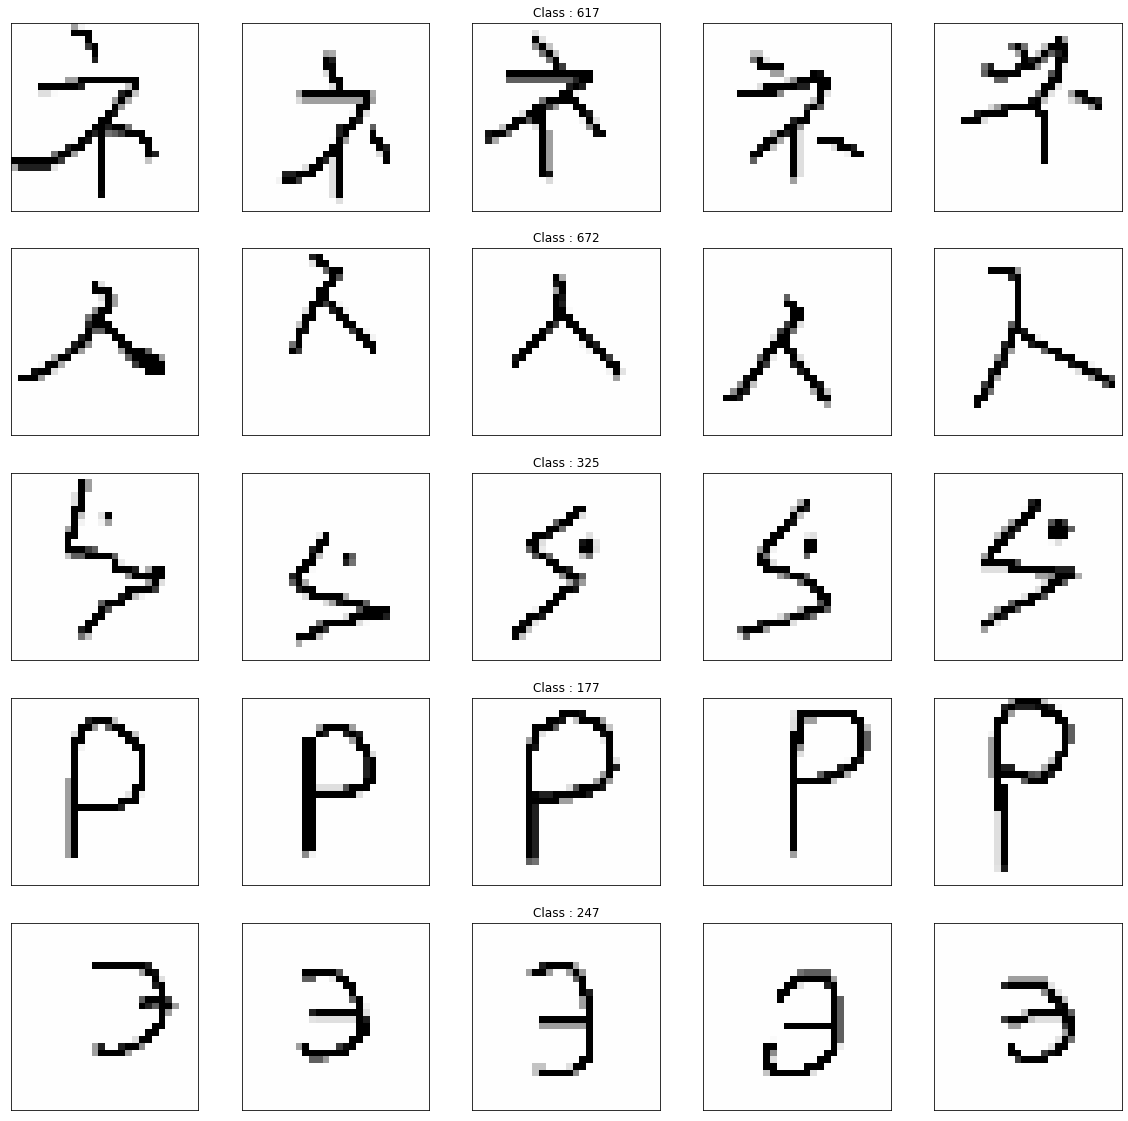

In [ ]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
    for b in range(5):
        temp_image = train_dataset.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image, cmap="gray")
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()


## Build the model


In [ ]:

def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)


inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)


## Train the model


In [ ]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1]) #not batch, isn't it meta iteration epoch?
            )


batch 0: train=0.600000 test=0.400000
batch 100: train=0.400000 test=0.000000
batch 200: train=1.000000 test=0.800000
batch 300: train=1.000000 test=0.400000
batch 400: train=1.000000 test=0.400000
batch 500: train=1.000000 test=0.800000
batch 600: train=1.000000 test=0.200000
batch 700: train=1.000000 test=0.600000
batch 800: train=1.000000 test=0.800000
batch 900: train=0.200000 test=1.000000
batch 1000: train=1.000000 test=1.000000
batch 1100: train=1.000000 test=0.600000
batch 1200: train=1.000000 test=0.800000
batch 1300: train=1.000000 test=0.400000
batch 1400: train=1.000000 test=0.800000
batch 1500: train=1.000000 test=0.400000
batch 1600: train=1.000000 test=0.400000
batch 1700: train=0.600000 test=0.600000
batch 1800: train=1.000000 test=0.400000
batch 1900: train=1.000000 test=0.400000


## Visualize Results


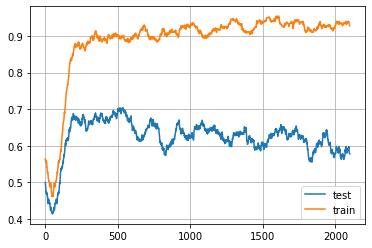

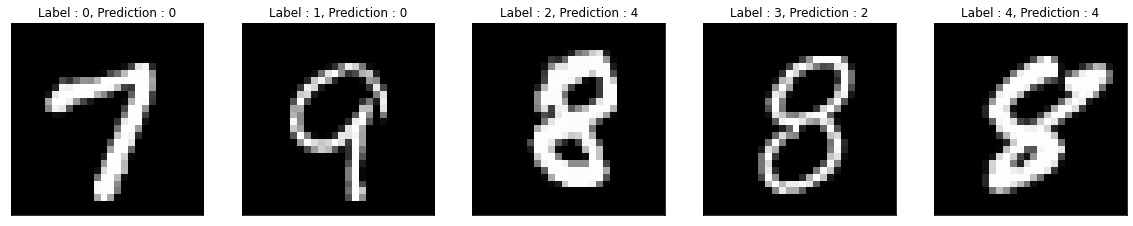

In [ ]:
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
# w = np.hamming(window_length)
w = np.ones(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
# x = np.arange(0, len(test_y), 1)
# plt.plot(x, test_y, x, train_y)
# plt.legend(["test", "train"])

x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])

plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()


# Experiments on Cifar100
Cifar100 -> Omniglot
Cifar100 -> MNIST


Libraries

In [ ]:
import urllib3
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

## Make Training Model and Visualizing into a function

In [ ]:
class Dataset_Experiment:
    # This class will facilitate the creation of a few-shot dataset
    # from the Omniglot dataset that can be sampled from quickly while also
    # allowing to create new labels at the same time.
    def __init__(self,training,dataset_name):
        # Download the tfrecord files containing the omniglot data and convert to a
        # dataset.
        # @param: dataset_name (str): the dataset that you want to download
        split = "train" if training else "test"
        if split == "test":
          ds = tfds.load(dataset_name, split=split, as_supervised=True, shuffle_files=False)
          # We want to test the model on some unseen data later after training
          self.unseen_data = tfds.load(dataset_name, split='train', as_supervised=True, shuffle_files=False)
        if split == "train":
          ds = tfds.load(dataset_name, split=split, as_supervised=True, shuffle_files=False)
        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.


        self.saved_split = split
        self.data = {}

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            print(image.shape)            
            image = tf.image.convert_image_dtype(image, tf.float32)

            if self.saved_split == "train" or True:
              image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
        self.labels = list(self.data.keys())

        if split == "test":
          self.unseen_images = {}
          for image,label in self.unseen_data.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.unseen_images:
              self.unseen_images[label] = []
            self.unseen_images[label].append(image)
          self.unseen_labels = list(self.unseen_images.keys())

    def get_mini_dataset(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.data[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]#np.mean(images_to_split[-1],axis=2,keepdims=True)#added to reduce dims to 28,28,1
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[-1]#np.mean(images_to_split[-1],axis=2,keepdims=True)
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset

    def get_mini_dataset_unseen(
        self, batch_size, repetitions, shots, num_classes, split=False
    ):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.unseen_labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(
                    self.unseen_images[label_subset[class_idx]], k=shots + 1
                )
                test_images[class_idx] = images_to_split[-1]#np.mean(images_to_split[-1],axis=2,keepdims=True)#added to reduce dims to 28,28,1
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = images_to_split[-1]#np.mean(images_to_split[-1],axis=2,keepdims=True)
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[
                    class_idx * shots : (class_idx + 1) * shots
                ] = random.choices(self.unseen_images[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices(
            (temp_images.astype(np.float32), temp_labels.astype(np.int32))
        )
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
        if split:
            return dataset, test_images, test_labels
        return dataset


# Helper for making the model
def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def Reptile_Experiment(train='cifar100',test='omniglot'):
  '''
  Will run Reptile training on train and testing on test
  @param: train (str): what data set to train on
  @param: test (str): what data set to test on
  '''
  # First we load the data:
  urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.
  train_dataset = Dataset_Experiment(training=True,dataset_name=train)
  test_dataset = Dataset_Experiment(training=False,dataset_name=test)
  # HyperParameters:
  learning_rate = 0.003
  meta_step_size = 0.25

  inner_batch_size = 25
  eval_batch_size = 25

  #meta iters should be 2000, previously 500
  meta_iters = 200  # 2000
  eval_iters = 5
  inner_iters = 4

  eval_interval = 1
  train_shots = 20
  shots = 5
  classes = 5

  # Make the Model
  inputs = layers.Input(shape=(28, 28, 1))
  x = conv_bn(inputs)
  x = conv_bn(x)
  x = conv_bn(x)
  x = conv_bn(x)
  x = layers.Flatten()(x)
  outputs = layers.Dense(classes, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile()
  optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
  
  # Perform Reptile Training
  training = []
  testing = []
  for meta_iter in range(meta_iters):
      frac_done = meta_iter / meta_iters
      cur_meta_step_size = (1 - frac_done) * meta_step_size
      # Temporarily save the weights from the model.
      old_vars = model.get_weights()
      # Get a sample from the full dataset.
      mini_dataset = train_dataset.get_mini_dataset(
          inner_batch_size, inner_iters, train_shots, classes
      )
      for images, labels in mini_dataset:
          with tf.GradientTape() as tape:
              preds = model(images)
              loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
          grads = tape.gradient(loss, model.trainable_weights)
          optimizer.apply_gradients(zip(grads, model.trainable_weights))
      new_vars = model.get_weights()
      # Perform SGD for the meta step.
      for var in range(len(new_vars)):
          new_vars[var] = old_vars[var] + (
              (new_vars[var] - old_vars[var]) * cur_meta_step_size
          )
      # After the meta-learning step, reload the newly-trained weights into the model.
      model.set_weights(new_vars)
      # Evaluation loop
      if meta_iter % eval_interval == 0:
          accuracies = []
          for dataset in (train_dataset, test_dataset):
              # Sample a mini dataset from the full dataset.
              train_set, test_images, test_labels = dataset.get_mini_dataset(
                  eval_batch_size, eval_iters, shots, classes, split=True
              )
              old_vars = model.get_weights()
              # Train on the samples and get the resulting accuracies.
              for images, labels in train_set:
                  with tf.GradientTape() as tape:
                      preds = model(images)
                      loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                  grads = tape.gradient(loss, model.trainable_weights)
                  optimizer.apply_gradients(zip(grads, model.trainable_weights))
              test_preds = model.predict(test_images)
              test_preds = tf.argmax(test_preds).numpy()
              num_correct = (test_preds == test_labels).sum()
              # Reset the weights after getting the evaluation accuracies.
              model.set_weights(old_vars)
              accuracies.append(num_correct / classes)
          training.append(accuracies[0])
          testing.append(accuracies[1])
          if meta_iter % 100 == 0:
              print(
                  "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
              )
  # Visualize Results:
  # First, some preprocessing to smooth the training and testing arrays for display.
  window_length = 100
  train_s = np.r_[
      training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
  ]
  test_s = np.r_[
      testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
  ]
  # w = np.hamming(window_length)
  w = np.ones(window_length)
  train_y = np.convolve(w / w.sum(), train_s, mode="valid")
  test_y = np.convolve(w / w.sum(), test_s, mode="valid")

  # Display the training accuracies.
  # x = np.arange(0, len(test_y), 1)
  # plt.plot(x, test_y, x, train_y)
  # plt.legend(["test", "train"])

  x = np.arange(0, len(test_y), 1)
  plt.plot(x, test_y, x, train_y)
  plt.legend(["test", "train"])

  plt.grid()

  # Now plot a few examples
  print("Training / Testing Phases over.")
  print("Let's see how it does on unseen data.")

  train_set, test_images, test_labels = dataset.get_mini_dataset_unseen(
      eval_batch_size, eval_iters, shots, classes, split=True
  )
  for images, labels in train_set:
      with tf.GradientTape() as tape:
          preds = model(images)
          loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
      grads = tape.gradient(loss, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
  test_preds = model.predict(test_images)
  test_preds = tf.argmax(test_preds).numpy()

  print("Length of Test Labels is ",len(test_labels))
  print("Length of Test preds is ",len(test_preds))
  print("\nTest Labels are ",test_labels)
  print("\nTest Predictions are ",test_preds)
  # Let's compare test_preds vs. labels
  correct,total = 0,0
  for pred,true in zip(test_preds,test_labels):
    if pred == true:
      correct+=1
    total+=1
  print("Accuracy on unseen data is ",correct/total)

  _, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

  sample_keys = list(train_dataset.data.keys())

  for i, ax in zip(range(5), axarr):
      temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
      temp_image *= 255
      temp_image = np.clip(temp_image, 0, 255).astype("uint8")
      ax.set_title(
          "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
      )
      ax.imshow(temp_image, cmap="gray")
      ax.xaxis.set_visible(False)
      ax.yaxis.set_visible(False)
  plt.show()

##### **Cifar100**->MNIST

(32, 32, 3)
(28, 28, 1)
batch 0: train=0.200000 test=0.200000
batch 100: train=0.000000 test=0.600000
batch 200: train=0.200000 test=0.400000
batch 300: train=0.000000 test=0.600000
batch 400: train=0.000000 test=1.000000
batch 500: train=0.400000 test=1.000000
batch 600: train=0.200000 test=1.000000
batch 700: train=0.200000 test=0.800000
batch 800: train=1.000000 test=0.600000
batch 900: train=0.400000 test=0.400000
batch 1000: train=0.400000 test=0.000000
batch 1100: train=0.400000 test=0.600000
batch 1200: train=0.400000 test=0.800000
batch 1300: train=0.000000 test=0.400000
batch 1400: train=0.400000 test=0.200000
batch 1500: train=0.400000 test=0.400000
batch 1600: train=0.000000 test=0.800000
batch 1700: train=0.400000 test=0.400000
batch 1800: train=0.400000 test=0.200000
batch 1900: train=0.400000 test=0.600000


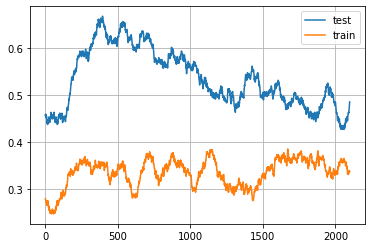

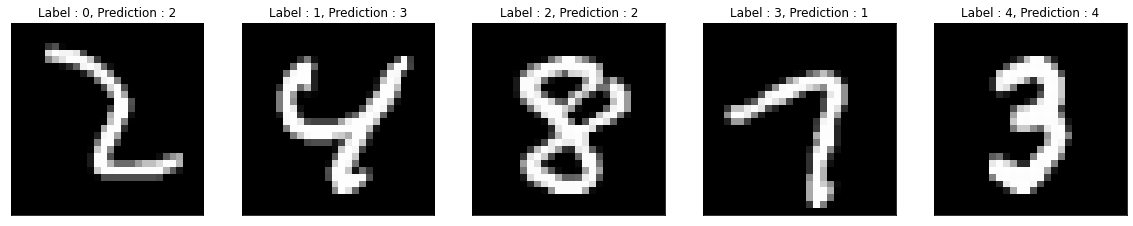

In [ ]:
Reptile_Experiment(train='cifar100',test='mnist')

##### Cifar100->Omniglot

(32, 32, 3)
(105, 105, 3)
(105, 105, 3)
batch 0: train=0.800000 test=1.000000
batch 100: train=1.000000 test=1.000000
Training / Testing Phases over.
Let's see how it does on unseen data.
Length of Test Labels is  5
Length of Test preds is  5

Test Labels are  [0. 1. 2. 3. 4.]

Test Predictions are  [1 1 4 3 4]
Accuracy on unseen data is  0.6


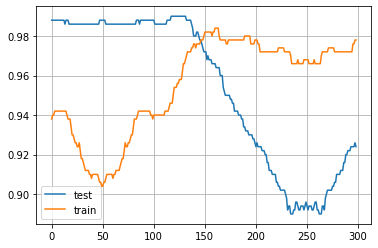

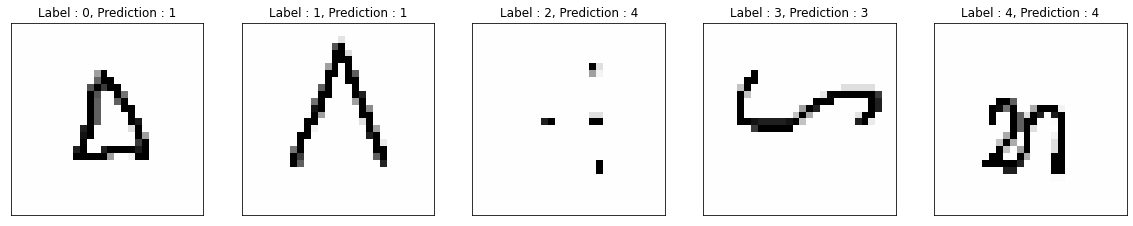

In [ ]:
Reptile_Experiment(train='cifar100',test='omniglot')

Below is output from April 27th

(32, 32, 3)
(105, 105, 3)
batch 0: train=1.000000 test=1.000000
batch 100: train=1.000000 test=1.000000
batch 200: train=1.000000 test=0.400000
batch 300: train=1.000000 test=0.600000
batch 400: train=1.000000 test=0.400000
batch 500: train=1.000000 test=0.400000
batch 600: train=1.000000 test=0.200000
batch 700: train=1.000000 test=0.200000
batch 800: train=1.000000 test=0.400000
batch 900: train=1.000000 test=0.400000
batch 1000: train=1.000000 test=0.200000
batch 1100: train=1.000000 test=0.200000
batch 1200: train=1.000000 test=0.200000
batch 1300: train=1.000000 test=0.400000
batch 1400: train=1.000000 test=0.200000
batch 1500: train=1.000000 test=0.400000
batch 1600: train=1.000000 test=0.400000
batch 1700: train=1.000000 test=0.200000
batch 1800: train=1.000000 test=0.200000
batch 1900: train=1.000000 test=0.200000


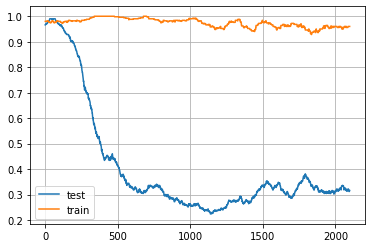

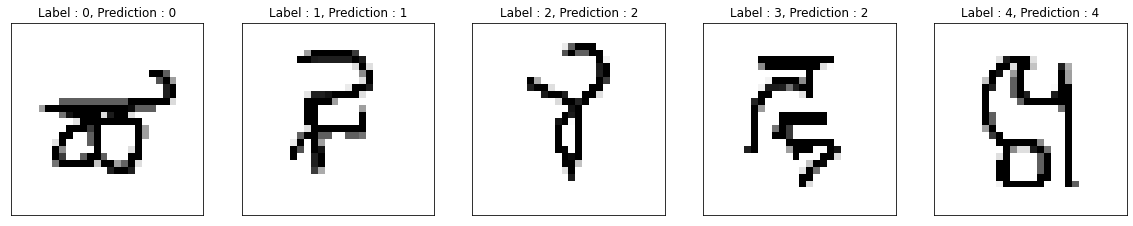

In [ ]:
Reptile_Experiment(train='cifar100',test='omniglot')

Train Reptile for 200, and then test on new unseen data